In [1]:
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.transforms import Compose
import random


In [2]:
rnn = nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

In [3]:
sample0, sr0 = librosa.load('Keystroke-Datasets/MBPWavs/0.wav')

In [4]:
# waveform function for me to not bang my keyboard
def disp_waveform(signal, sr=None, color='blue'):
    plt.figure(figsize=(7,2))
    return librosa.display.waveshow(signal, sr=sr, color=color)

In [5]:
def isolator(signal, sample_rate, n_fft, hop_length, before, after, threshold, show=False):
    strokes = []
    # -- signal'
    if show:
        disp_waveform(signal, sr=sample_rate)
    fft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    energy = np.abs(np.sum(fft, axis=0)).astype(float)
    # norm = np.linalg.norm(energy)
    # energy = energy/norm
    # -- energy'
    if show:
        disp_waveform(energy)
    threshed = energy > threshold
    # -- peaks'
    if show:
        disp_waveform(threshed.astype(float))
    peaks = np.where(threshed == True)[0]
    peak_count = len(peaks)
    prev_end = sample_rate*0.1*(-1)
    # '-- isolating keystrokes'
    for i in range(peak_count):
        this_peak = peaks[i]
        timestamp = (this_peak*hop_length) + n_fft//2
        if timestamp > prev_end + (0.1*sample_rate):
            keystroke = signal[timestamp-before:timestamp+after]
            # strokes.append(torch.tensor(keystroke)[None, :])
            # keystroke = transform(keystroke)
            strokes.append(keystroke)
            if show:
                disp_waveform(keystroke, sr=sample_rate)
            prev_end = timestamp+after
    return strokes

In [6]:
# Constants we actually need for the task
MBP_AUDIO_DIR = '/Users/jorgeleon/Keystroke-Datasets/MBPWavs/'
keys_s = '1234567890QWERTYUIOPASDFGHJKLZXCVBNM'
# keys_s = '12'
labels = list(keys_s)
keys = [k + '.wav' for k in labels]
data_dict = {'Key':[], 'File':[]}
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [7]:
def create_dataset(n_fft, hop_length, before, after):
    for i, File in enumerate(keys):
        loc = MBP_AUDIO_DIR + File
        samples, sr = librosa.load(loc)
        prom = 0.06
        step = 0.005
        strokes = isolator(samples, sr, n_fft, hop_length, before, after, prom, False )
        print(f'File {File} length: {len(strokes)}')
        label = [labels[i]]*len(strokes)
        data_dict['Key'] += label
        data_dict['File'] += strokes

    df = pd.DataFrame(data_dict)
    mapper = {}
    counter = 0
    for l in df['Key']:
        if not l in mapper:
            mapper[l] = counter
            counter += 1
    df.replace({'Key': mapper}, inplace = True)

    return df

In [8]:
for key in keys_s:
    sample, sr = librosa.load(f'Keystroke-Datasets/MBPWavs/{key}.wav')
    print(sr)
    print(len(isolator(sample, sr, 1024, 225, 2400, 12000, 0.06)), end=' ')
    

22050
25 22050
25 22050
25 22050
25 22050
25 22050
26 22050
25 22050
25 22050
27 22050
26 22050
27 22050
28 22050
28 22050
25 22050
26 22050
25 22050
25 22050
25 22050
25 22050
25 22050
25 22050
25 22050
25 22050
27 22050
26 22050
25 22050
27 22050
25 22050
25 22050
25 22050
26 22050
26 22050
25 22050
25 22050
25 22050
26 

In [9]:
n_fft = 1024
hop_length = 225
before = 2400
after = 12000
mbp_dataset = create_dataset(n_fft, hop_length, before, after)
mbp_dataset

File 1.wav length: 25
File 2.wav length: 25
File 3.wav length: 25
File 4.wav length: 25
File 5.wav length: 25
File 6.wav length: 26
File 7.wav length: 25
File 8.wav length: 25
File 9.wav length: 27
File 0.wav length: 26
File Q.wav length: 27
File W.wav length: 28
File E.wav length: 28
File R.wav length: 25
File T.wav length: 26
File Y.wav length: 25
File U.wav length: 25
File I.wav length: 25
File O.wav length: 25
File P.wav length: 25
File A.wav length: 25
File S.wav length: 25
File D.wav length: 25
File F.wav length: 27
File G.wav length: 26
File H.wav length: 25
File J.wav length: 27
File K.wav length: 25
File L.wav length: 25
File Z.wav length: 25
File X.wav length: 26
File C.wav length: 26
File V.wav length: 25
File B.wav length: 25
File N.wav length: 25
File M.wav length: 26


/var/folders/dr/8bpx1vc91zq76n48xvq00vkr0000gn/T/ipykernel_38603/2996179166.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'Key': mapper}, inplace = True)


,Key,File
0,0,"[-0.00017975704, -0.00012727435, -9.371067e-05..."
1,0,"[0.0004975861, 0.00049031794, 0.00055128767, 0..."
2,0,"[0.0003178973, 0.00034715654, 0.00037197635, 0..."
3,0,"[0.0026817801, 0.0026667325, 0.0026979204, 0.0..."
4,0,"[0.006475482, 0.006330982, 0.0053669773, 0.003..."
...,...,...
916,35,"[-0.250816, -0.25290227, -0.2548398, -0.256657..."
917,35,"[0.13746458, 0.13331993, 0.12892574, 0.1242145..."
918,35,"[0.0017171799, 0.0016756048, 0.0016776036, 0.0..."
919,35,"[-0.00014814897, -0.00018149195, -0.0002237717..."


In [10]:
audio_samples = mbp_dataset['File'].values.tolist()
labels = mbp_dataset['Key'].values.tolist()

audioDataset = np.array(audio_samples, dtype = object)
print(audio_samples[0].shape)
mfcc = librosa.feature.mfcc(y=audio_samples[0], sr=44100) # shape: (n_mfcc, t)
print(mfcc.shape)
# labels = np.array(labels)

(14400,)
(20, 29)


In [11]:
class TimeShifting():
    def __call__(self, samples):
#       samples_shape = samples.shape
        samples = samples.flatten()
        
        shift = int(len(samples) * 0.4) #Max shift (0.4)
        random_shift = random.randint(0, shift) #Random number between 0 and 0.4*len(samples)
        data_roll = np.roll(samples, random_shift)
        return data_roll

In [12]:

def time_shift(samples):
    samples = samples.flatten()
    shift = int(len(samples) * 0.4) #Max shift (0.4)
    random_shift = random.randint(0, shift) #Random number between 0 and 0.4*len(samples)
    data_roll = np.roll(samples, random_shift)
    return data_roll

In [13]:
from skimage.transform import resize


class ToMelSpectrogram:
    def __init__(self, audio_length=14400):
        self.audio_length = audio_length

    def __call__(self, samples):
        if len(samples) > self.audio_length:
            samples = samples[:self.audio_length]
        elif len(samples) < self.audio_length:
            samples = np.pad(samples, (0, self.audio_length - len(samples)), mode='constant')

        mel_spec = librosa.feature.melspectrogram(y=samples, sr=44100, n_mels=64, n_fft=1024, hop_length=225)
        mel_spec_resized = resize(mel_spec, (64, 64), anti_aliasing=True)
        mel_spec_resized = np.expand_dims(mel_spec_resized, axis=0)
        return torch.tensor(mel_spec_resized)


class ToMelSpectrogramMfcc:
    def __init__(self, audio_length=14400):
        self.audio_length = audio_length

    def __call__(self, samples):
        if len(samples) > self.audio_length:
            samples = samples[:self.audio_length]
        elif len(samples) < self.audio_length:
            samples = np.pad(samples, (0, self.audio_length - len(samples)), mode='constant')

        mel_spec = librosa.feature.melspectrogram(y=samples, sr=44100, n_mels=64, n_fft=n_fft, hop_length=hop_length)
        mel_spec = librosa.feature.mfcc(S=librosa.power_to_db(mel_spec))
        mel_spec_resized = resize(mel_spec, (64, 64), anti_aliasing=True)
        mel_spec_resized = np.expand_dims(mel_spec_resized, axis=0)

        return torch.tensor(mel_spec_resized)


class ToMfcc:
    def __init__(self, audio_length=14400):
        self.audio_length = audio_length

    def __call__(self, samples):
        if len(samples) > self.audio_length:
            samples = samples[:self.audio_length]
        elif len(samples) < self.audio_length:
            samples = np.pad(samples, (0, self.audio_length - len(samples)), mode='constant')
        
        mfcc_spec = librosa.feature.mfcc(y=samples, sr=44100)
        mfcc_spec = np.transpose(mfcc_spec)
        return torch.tensor(mfcc_spec)


In [14]:
transform = Compose([ToMelSpectrogram()])
transform_mfcc = Compose([ToMfcc()])

In [15]:
audio_samples_new = audio_samples.copy() # audio samples CNN

for i, sample in enumerate(audio_samples):
    audio_samples_new.append(time_shift(sample))
    labels.append(labels[i])
    
# convert labels to a numpy array
labels = np.array(labels)
print(len(audio_samples_new))
print(len(labels))

1842
1842


In [16]:
audioDatasetFin, audioDatasetMfcc = [], []

for i in range(len(audio_samples_new)):
    transformed_sample = transform(audio_samples_new[i])
    transformed_mfcc = transform_mfcc(audio_samples_new[i])
    audioDatasetFin.append((transformed_sample, labels[i]))
    audioDatasetMfcc.append((transformed_sample, transformed_mfcc, labels[i]))

In [17]:
len(audioDatasetFin)

1842

In [18]:
audioDatasetMfcc[0][0].shape

torch.Size([1, 64, 64])

In [60]:
import time

class MfccLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.2, num_classes=36):
        super(MfccLSTM, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.LazyLinear(512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc1 = nn.LazyLinear(64)
        self.fc2 = nn.Linear(64, 16)
        
        # self.lstm = nn.Sequential(
        #     nn.LSTM(input_size, hidden_size, batch_first=True),
        #     nn.Dropout(dropout),
        #     nn.LSTM(hidden_size, hidden_size, batch_first=True),
        #     nn.Dropout(dropout),
        #     nn.LazyLinear(256),
        #     nn.Linear(256, output_size)
        # )
        
        self.fc3 = nn.LazyLinear(128)
        self.final_lstm = nn.LSTM(1, 64, batch_first=True)
        
        self.fc = nn.LazyLinear(num_classes)
    
    def forward(self, image_input, sequence_input):
        # must return shape (batch_size, num_classes) 
        # batch_size: right now is 16
        # num_classes: right now is 36
        x1 = self.conv(image_input)
        # print(f'output of convolutional part: {x1.shape[1:]}')
        # print("after conv layer1")
        # print('got here x1')
        # must return shape (batch_size, output_size)
        # output_size: should be 36
        # # # print(sequence_input.shape)
        out1, _ = self.lstm(sequence_input)
        out1_dp = self.dropout(out1)
        # print(f'output of first lstm: {out1_dp.shape[1:]}')
        out2, _ = self.lstm2(out1_dp[:, -1, :])
        out2_dp = self.dropout(out2)
        # print(f'output of second lstm: {out2_dp.shape[1:]}')
        x2 = self.fc2(self.fc1(out2_dp))
        x3 = torch.cat((x1, x2), 1)
        # print(f'output of concatenation: {x3.shape[1:]}')
        # x4 = self.fc3(x3)
        # final_out, _ = self.final_lstm(torch.unsqueeze(x4, dim=2))
        # print(f'output of final lstm: {final_out[:, -1, :].shape[1:]}')
        # x = self.fc(final_out[:, -1, :])
        # print(f'output of final linear layer: {x.shape[1:]}')
        # print()
        x = self.fc(x3)
        return x
    

In [61]:
# Model architecture
class CNN(nn.Module):
    def __init__(self, num_classes=36):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.LazyLinear(512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [62]:
import time

def train(dataset, num_epochs, model_path, leave_one_out=False):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    if leave_one_out:
        train_set, val_set = dataset[:-1], [dataset[-1]]
    else:
        train_set, val_set = train_test_split(dataset, test_size=0.15)
    train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=16, shuffle=True)
    
    # print("Before initialization of the model")
    model = MfccLSTM(input_size=20, hidden_size=32, num_classes=36, output_size=64)
    # print("After initialization of the model")
    model = model.to(device)
    # print("Model to GPU")
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    criterion = nn.CrossEntropyLoss()
    # criterion = nn.BCELoss()
    # criterion = nn.BCEWithLogitsLoss()
    
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        correct_train = 0  # correct training examples
        total_train = 0 # total training examples
        tic = time.perf_counter()
        
        # print(f'---- EPOCH {epoch} ----')
        # print("Before entering the inner loop")
        for images, sequences, labels in train_loader:
            images = images.to(device)
            sequences = sequences.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images, sequences)
            # time.sleep(1)
            loss = criterion(outputs, labels)
            epoch_train_loss += loss.item() * images.size(0)

            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
        toc = time.perf_counter()
        time_taken = toc - tic
        
        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        # Evaluation of the model
        model.eval()
        total, correct = 0, 0
        for images, sequences, labels  in val_loader:
            images = images.to(device)
            sequences = sequences.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images, sequences)
            _, predicted = torch.max(outputs.data, 1)
            # predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        val_accuracy = correct / total
        print(f'correct: {correct}, total: {total}')
        print(f'val_accuracy: {val_accuracy:.4f}')
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} / Val Accuracy: {val_accuracy:.4f} Iter Time: {time_taken:.2f}s")
        
        if epoch == num_epochs - 1 and epoch != 0:
            plt.plot(range(epoch+1), train_accuracies, label='Training Accuracy', color="blue")
            plt.plot(range(epoch+1), val_accuracies, label='Validation Accuracy', color="orange")
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.title(f'Training vs Validation Accuracy')
            plt.legend()
            plt.show()
        
        print()
    torch.save(model.state_dict(), model_path)

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


correct: 34, total: 277
val_accuracy: 0.1227
Epoch [1/500], Train Loss: 3.4612, Train Accuracy: 0.0569 / Val Accuracy: 0.1227 Iter Time: 1.34s

correct: 73, total: 277
val_accuracy: 0.2635
Epoch [2/500], Train Loss: 2.7910, Train Accuracy: 0.1700 / Val Accuracy: 0.2635 Iter Time: 0.98s

correct: 78, total: 277
val_accuracy: 0.2816
Epoch [3/500], Train Loss: 2.2875, Train Accuracy: 0.3131 / Val Accuracy: 0.2816 Iter Time: 0.97s

correct: 104, total: 277
val_accuracy: 0.3755
Epoch [4/500], Train Loss: 1.9197, Train Accuracy: 0.4013 / Val Accuracy: 0.3755 Iter Time: 0.97s

correct: 114, total: 277
val_accuracy: 0.4116
Epoch [5/500], Train Loss: 1.6562, Train Accuracy: 0.4818 / Val Accuracy: 0.4116 Iter Time: 0.96s

correct: 131, total: 277
val_accuracy: 0.4729
Epoch [6/500], Train Loss: 1.4401, Train Accuracy: 0.5399 / Val Accuracy: 0.4729 Iter Time: 0.97s

correct: 145, total: 277
val_accuracy: 0.5235
Epoch [7/500], Train Loss: 1.2298, Train Accuracy: 0.5917 / Val Accuracy: 0.5235 Iter T

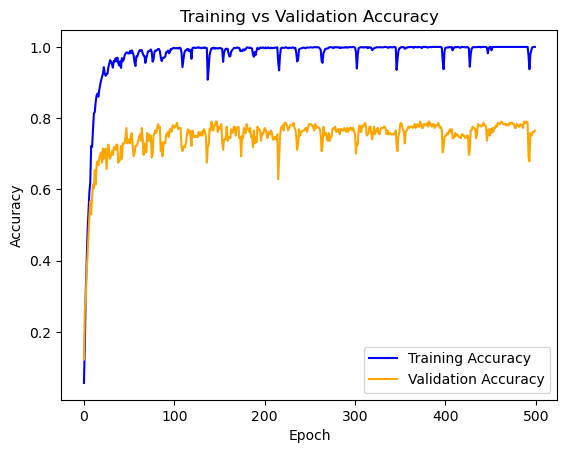

In [63]:
train(audioDatasetMfcc, 500, "model_multiclass_200_cnnlstm_finallstm_19_08_24.pth")